In [31]:
import sys
import os
sys.path.append(os.path.abspath(".."))

import re
import multiprocessing
from collections import Counter
import itertools
import json
from IPython.display import display as disp

import numpy as np
# import bottleneck as bn
import pandas as pd
import networkx as nx
# import igraph as ig
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='paper', style='whitegrid', color_codes=True, font_scale=1.8)
colorcycle = [(0.498, 0.788, 0.498),
              (0.745, 0.682, 0.831),
              (0.992, 0.753, 0.525),
              (0.220, 0.424, 0.690),
              (0.749, 0.357, 0.090),
              (1.000, 1.000, 0.600),
              (0.941, 0.008, 0.498),
              (0.400, 0.400, 0.400)]
%matplotlib inline
sns.set_palette(colorcycle)
mpl.rcParams['figure.max_open_warning'] = 65
mpl.rcParams['figure.figsize'] = [12, 7]
mpl.rcParams['text.usetex'] = False

# import warnings
# warnings.simplefilter("ignore", category=DeprecationWarning)
# warnings.simplefilter("ignore", category=mpl.cbook.mplDeprecation)
# warnings.simplefilter("ignore", category=UserWarning)


from speclib import misc, loaders, graph, plotting

pd.set_option('display.max_rows', 55)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 1000)
np.set_printoptions(linewidth=145)

# import pixiedust

In [33]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.decomposition import PCA, RandomizedPCA 

# The data

`x` indicates activity, partitioned into eight quarters, for the four channels ABCD.
`y` indicates movement.

In [22]:
data_path = '../../allan_data/DataPredictMovement_half.p'

In [23]:
x, y = np.load(data_path) 

Plotting the average value of the `x`-vectors, we see that every first quarter of an lower amound of activity. This could reflect human behaviour, because events often start on an hourly basis, or it could be a binning problem.

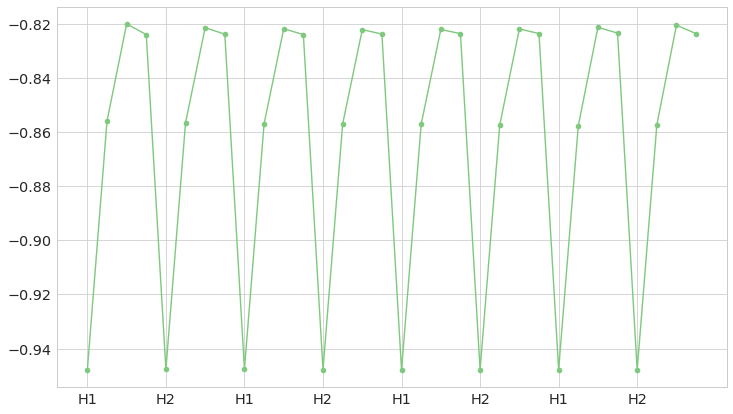

In [73]:
fig, ax = plt.subplots()
ax.plot(x.mean(axis=0), 'o-', c=colorcycle[0])
# xticks = np.array([np.array([0, 3]) + (i*4) for i in range(0, 8)]).ravel()
xticks = np.arange(0, 32, 4)
ax.set_xticks(xticks)
ax.set_xticklabels(["H1", "H2"]*4);

Below is the average of the four quarters in an hour. The same effect with low counts in the first quarter is seen.

In [8]:
means = np.zeros(4)
base_idx = np.arange(0, 32, 4)
for i in range(4):
    idx = base_idx + i
    icut = min(base_idx[-1]+i, x.shape[1])
    idx = idx[idx <= icut]
    arr = x[:, base_idx + i]
    means[i] = arr.mean()
    print("%.3f" % means[i])


-0.948
-0.857
-0.821
-0.824


Heatmap of the correlation shows the same pattern... perhaps a dimmensionality reduction is in order, since the intrinsic dimmension of the data might be quite a bit smaller than the current dimmensionalty.

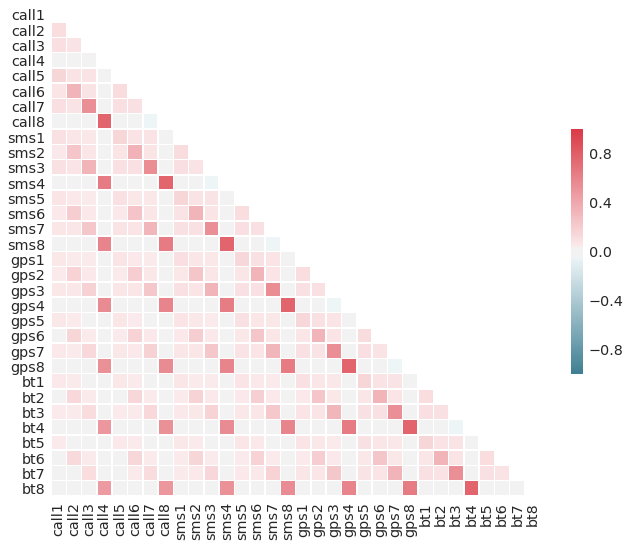

In [35]:
dfs = df.sample(df.shape[0]//25)
dfs.drop('move', axis=1, inplace=True)

corr = dfs.corr() 


with sns.axes_style("white"):
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}) 

In [74]:
pca = PCA() 
pca.fit(x)
xx = pca.transform(x)

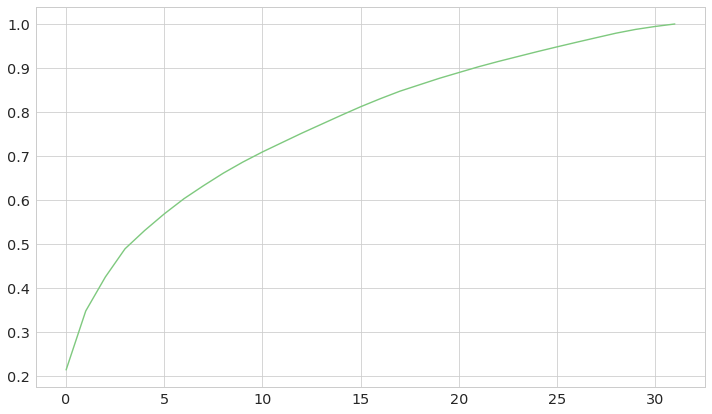

In [75]:
fig, ax = plt.subplots()
ax.plot(pca.explained_variance_ratio_.cumsum())

In [79]:
lrc_cv = LogisticRegressionCV(n_jobs=42, scoring='accuracy', penalty='l2', cv=5)

In [80]:
x.shape

(6549096, 32)

In [81]:
y.shape

(6549096,)

In [82]:
lrc_cv.fit(x[:10000, :], y[:10000])

LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=42, penalty='l2', random_state=None,
           refit=True, scoring='accuracy', solver='lbfgs', tol=0.0001,
           verbose=0)

In [83]:
yhat = lrc_cv.predict_proba(x)

In [84]:
yhat.shape

(6549096, 2)

In [86]:
yhat[:15, :]

array([[0.94836756, 0.05163244],
       [0.94816886, 0.05183114],
       [0.975408  , 0.024592  ],
       [0.96692462, 0.03307538],
       [0.95977843, 0.04022157],
       [0.96692462, 0.03307538],
       [0.96692462, 0.03307538],
       [0.91434223, 0.08565777],
       [0.96692462, 0.03307538],
       [0.90047052, 0.09952948],
       [0.51782809, 0.48217191],
       [0.96692462, 0.03307538],
       [0.48645802, 0.51354198],
       [0.96692462, 0.03307538],
       [0.96692462, 0.03307538]])

In [87]:
yy = y.copy() 

In [88]:
yy[yy == -1] = 0

In [89]:
yy.shape

(6549096,)

In [90]:
yhat.shape

(6549096, 2)

AUC is 0.829


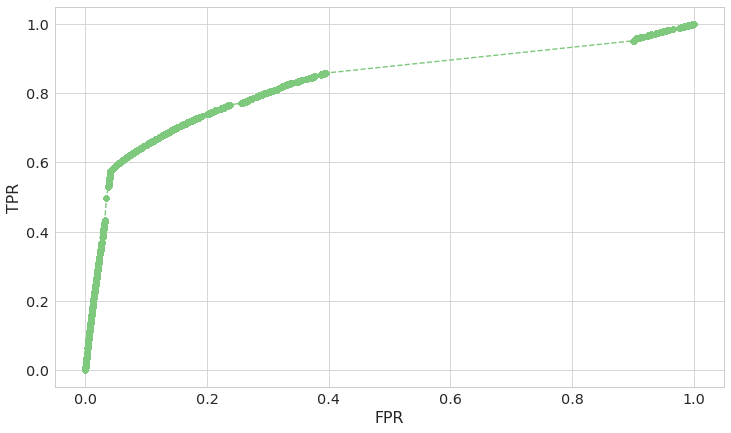

In [91]:
fpr, tpr, thr = metrics.roc_curve(y, yhat[:, 1])

fig, ax = plt.subplots()
ax.plot(fpr, tpr, 'o--')
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")
auc = metrics.auc(fpr, tpr)
print(f"AUC is {auc:.3f}")

In [ ]:
svc = SVC()
svc.fit(x, y)
yy_svc = svc.predict_proba(x)


In [ ]:
fpr, tpr, thr = metrics.roc_curve(y, yy_svc[:, 1])

fig, ax = plt.subplots()
ax.plot(fpr, tpr, 'o--')
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")
auc = metrics.auc(fpr, tpr)
print(f"AUC is {auc:.3f}")